In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
def read_data(file_path):
    # Skip the first 22 header lines
    label = file_path.split('/')[-1].split('.')[0]
    data = np.loadtxt(file_path, skiprows=22)
    
    # First column: sample number (convert to int), second column: velocity (float)
    sample_numbers = data[:, 0].astype(int)
    velocities = data[:, 1].astype(float)
    return [sample_numbers, velocities, label]

In [3]:
def plot_data(data_sets):
    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Plot each dataset with a different marker from 11 distinct options
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>', 'H']  # choose 11 different markers

    # choose 11 colors from the tab10 colormap
    colors = plt.get_cmap('tab10').colors

    # Plot each dataset
    for i, set in enumerate(data_sets):
        plt.scatter(set[0], set[1], label=set[2], marker=markers[i % len(markers)], facecolors='none', edgecolors=colors[i % len(colors)])

    # Add titles and labels
    plt.title('Velocity vs Sample Number')
    plt.xlabel('Sample Number')
    plt.ylabel('Velocity')

    # Customize ticks for the horizontal axis
    plt.gca().xaxis.set_major_locator(MultipleLocator(25_000))  # Major ticks every 25,000
    plt.gca().xaxis.set_minor_locator(MultipleLocator(12_500))  # Minor ticks every 12,500
    plt.xlim(0)  # Start the horizontal axis at 0

    # Customize ticks for the vertical axis
    plt.gca().yaxis.set_major_locator(MultipleLocator(5))  # Major ticks every 5
    plt.gca().yaxis.set_minor_locator(MultipleLocator(2.5))  # Minor ticks every 2.5

    # Add the legend and show the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

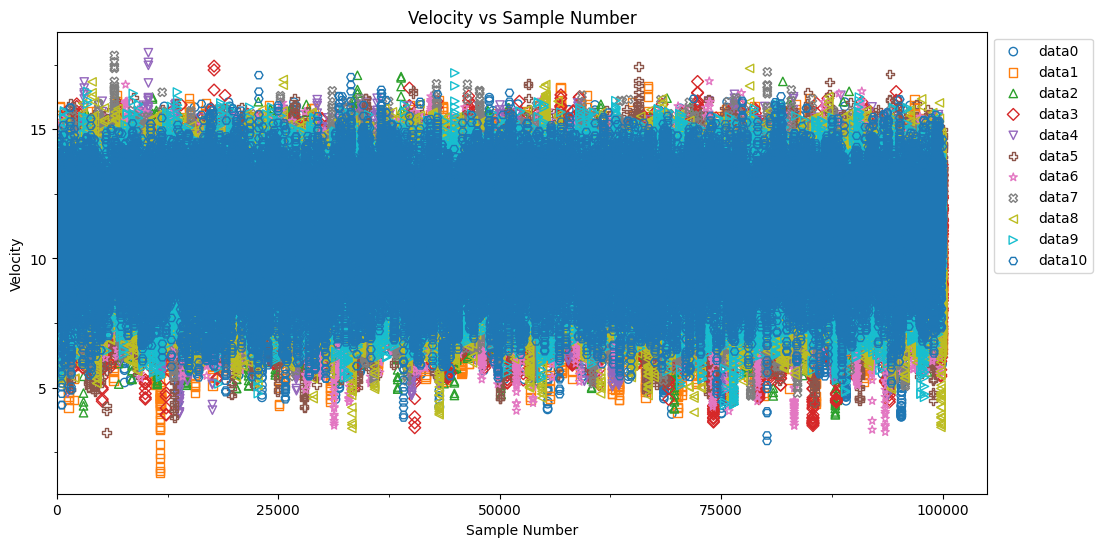

In [4]:
# Read in each dataset file
set0 = read_data('f15000/data0.lvm')
set1 = read_data('f15000/data1.lvm')
set2 = read_data('f15000/data2.lvm')
set3 = read_data('f15000/data3.lvm')
set4 = read_data('f15000/data4.lvm')
set5 = read_data('f15000/data5.lvm')
set6 = read_data('f15000/data6.lvm')
set7 = read_data('f15000/data7.lvm')
set8 = read_data('f15000/data8.lvm')
set9 = read_data('f15000/data9.lvm')
set10 = read_data('f15000/data10.lvm')
data_sets = [set0, set1, set2, set3, set4, set5, set6, set7, set8, set9, set10]

# Plot the datasets
plot_data(data_sets)

In [5]:
# Compute the FFT magnitude for the whole set or in windows, and return magnitude and frequencies
def compute_fft(velocities, record_size=None):
    velocities = np.asarray(velocities)
    n = len(velocities) if record_size is None else record_size
    sampling_rate = 15000  # samples per second
    
    if record_size is None or record_size >= len(velocities):
        # Compute FFT for the whole set
        fft_result = np.fft.fft(velocities, n=n)
        fft_magnitude = np.abs(fft_result)[:n//2]
        fft_freq = np.fft.fftfreq(n)[:n//2] * sampling_rate
        return fft_freq, fft_magnitude
    
    # Windowed FFT
    num_windows = len(velocities) // record_size
    fft_results = []
    for i in range(num_windows):
        start = i * record_size
        end = start + record_size
        window_data = velocities[start:end]
        fft_result = np.fft.fft(window_data)
        fft_magnitude = np.abs(fft_result)[:record_size//2]
        fft_results.append(fft_magnitude)
    
    '''
    # Handle any remaining data (zero-pad to record_size)
    if len(velocities) % record_size != 0:
        window_data = velocities[num_windows * record_size:]
        pad_width = record_size - len(window_data)
        window_data = np.pad(window_data, (0, pad_width), 'constant')
        fft_result = np.fft.fft(window_data)
        fft_magnitude = np.abs(fft_result)[:record_size//2]
        fft_results.append(fft_magnitude)
    '''
    
    fft_freq = np.fft.fftfreq(record_size)[:record_size//2] * sampling_rate
    return fft_freq, fft_results

# Plot FT magnitude for different record sizes on a log-log plot
def plot_fft_magnitudes(data, record_sizes=[None, 256, 2048, 16384]):
    velocities = data[1]
    plt.figure(figsize=(12, 6))

    # Plot each record size
    for rec_size in record_sizes:
        freq, mag = compute_fft(velocities, record_size=rec_size)
        if rec_size is None:
            plt.plot(freq[1:], mag[1:], label='Whole set', linestyle='--', color='k')
        else:
            # Compute average magnitude across windows
            ave_mag = np.mean(mag, axis=0)
            plt.plot(freq[1:], ave_mag[1:], label=f'Record Size: {rec_size}')  # skip DC component
    
    # Adjust plot settings
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Average FT Magnitude vs Frequency for Different Record Sizes for {data[2]}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [6]:
def fft_average(data, record_sizes=[256, 2048, 16384]):
    velocities = data[1]
    frequencies, all_fft_mag = compute_fft(velocities, record_size=None)
    for f in frequencies:
        print(f)
    for rec_size in record_sizes:
        # Compute FFT for the given record size
        fft_freq, fft_mag = compute_fft(velocities, record_size=rec_size)
        print(f'\nRec Size {rec_size}:')
        for f in fft_freq:
            print(f)
        ave_mag = np.mean(fft_mag, axis=0)

        # Pad the FFT array to match the size of the whole set FFT for averaging
        pad_width = len(all_fft_mag) - len(ave_mag)
        padded = []
        for i in range(len(fft_mag)):
            if pad_width > 0:
                padded.append(np.pad(fft_mag[i], (pad_width, 0), 'constant', constant_values=0))
            else:
                padded.append(fft_mag[i])
        padded.append(all_fft_mag)
        all_ave_padded = np.mean(padded, axis=0)

        # Plot the whole set FFT, average FFT for the record size, and overall average
        plot_fft_averages([[all_fft_mag, frequencies, 'Whole Set'], [ave_mag, fft_freq, f'Record Size {rec_size}'], [all_ave_padded, frequencies, 'Average']], rec_size)

def plot_fft_averages(data, record_size):
    plt.figure(figsize=(12, 6))
    for fft in data:
        mag, freqs, label = fft
        plt.plot(freqs[1:], mag[1:], label=label)  # skip DC component
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'FFT Magnitudes for Record Size {record_size}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

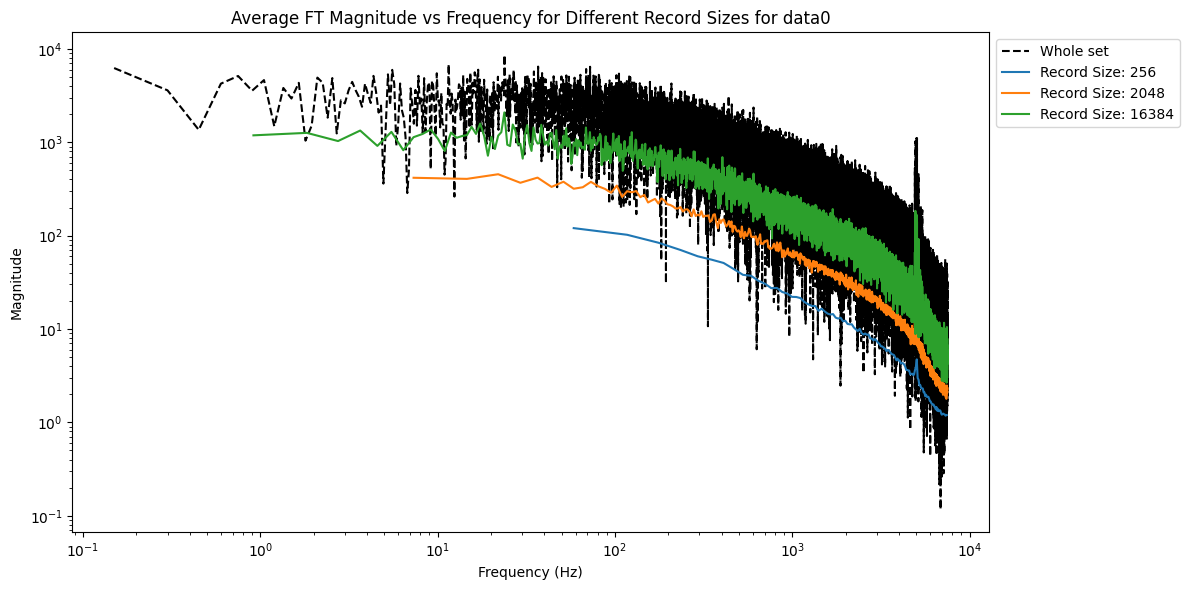

In [ ]:
# Plot FFT magnitudes for set0
plot_fft_magnitudes(set0)

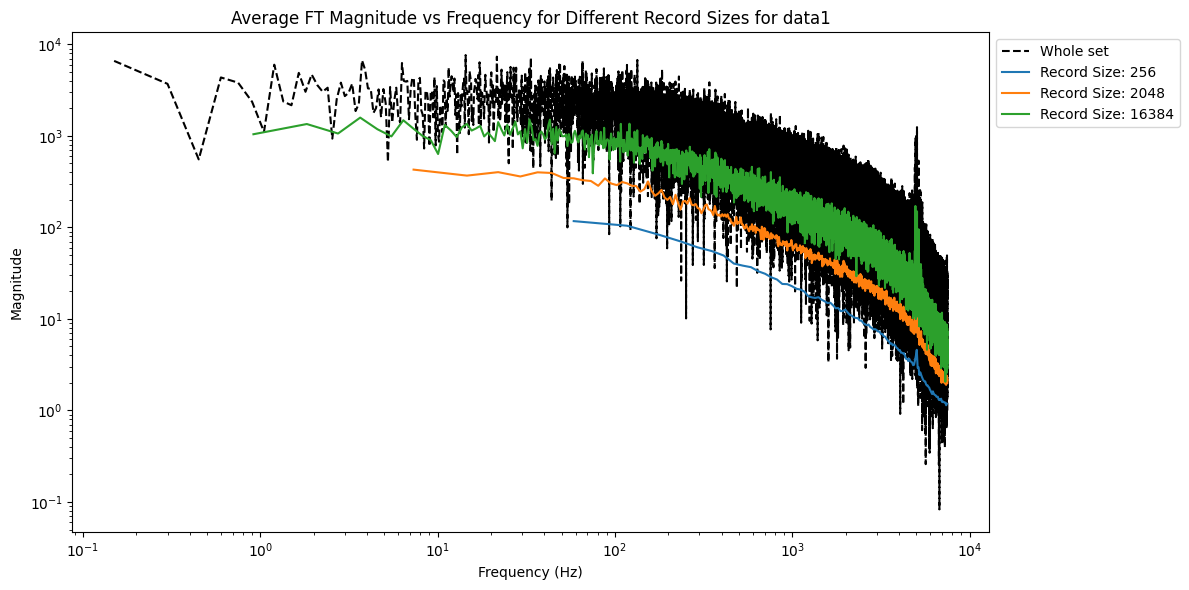

In [8]:
# Plot FFT magnitudes for set1
plot_fft_magnitudes(set1)

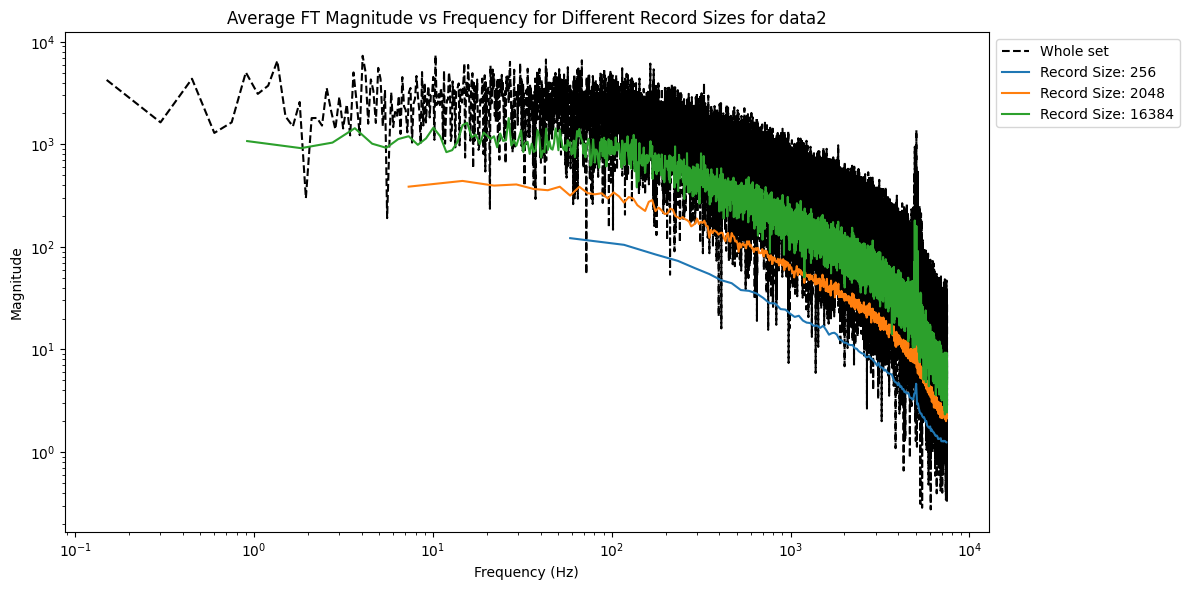

In [9]:
# Plot FFT magnitudes for set2
plot_fft_magnitudes(set2)

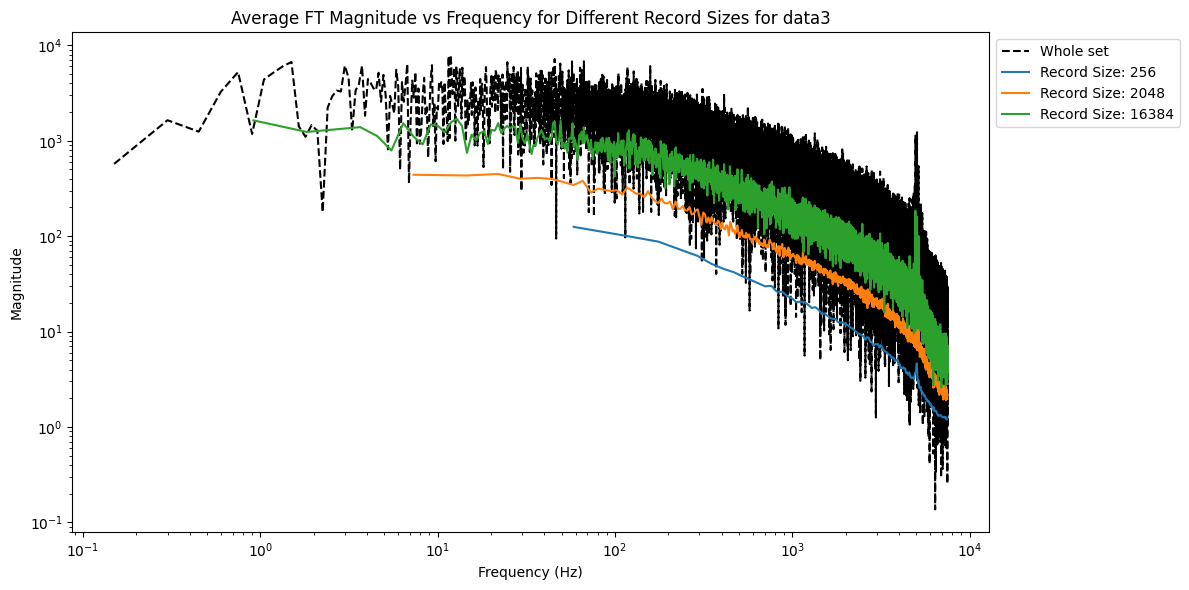

In [10]:
# Plot FFT magnitudes for set3
plot_fft_magnitudes(set3)

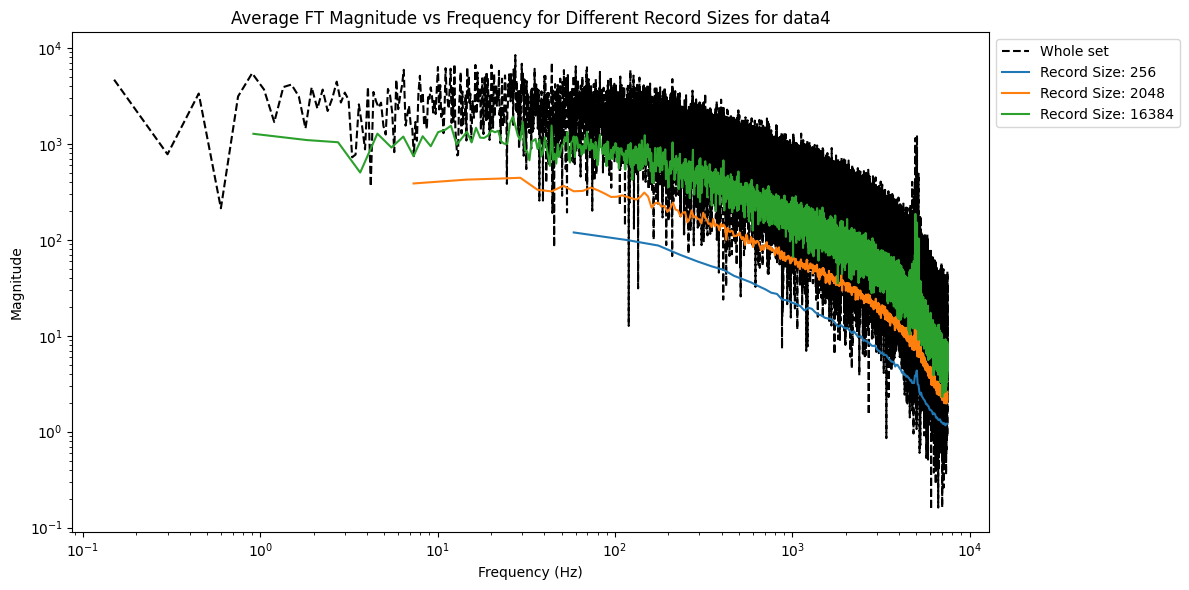

In [11]:
# Plot FFT magnitudes for set4
plot_fft_magnitudes(set4)

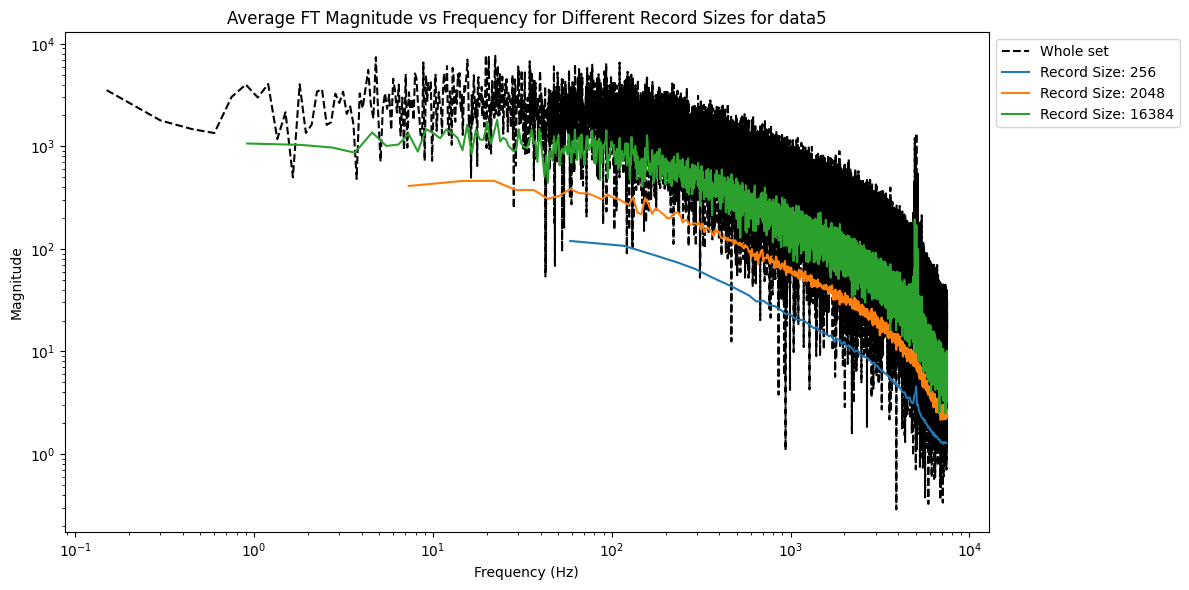

In [12]:
# Plot FFT magnitudes for set5
plot_fft_magnitudes(set5)

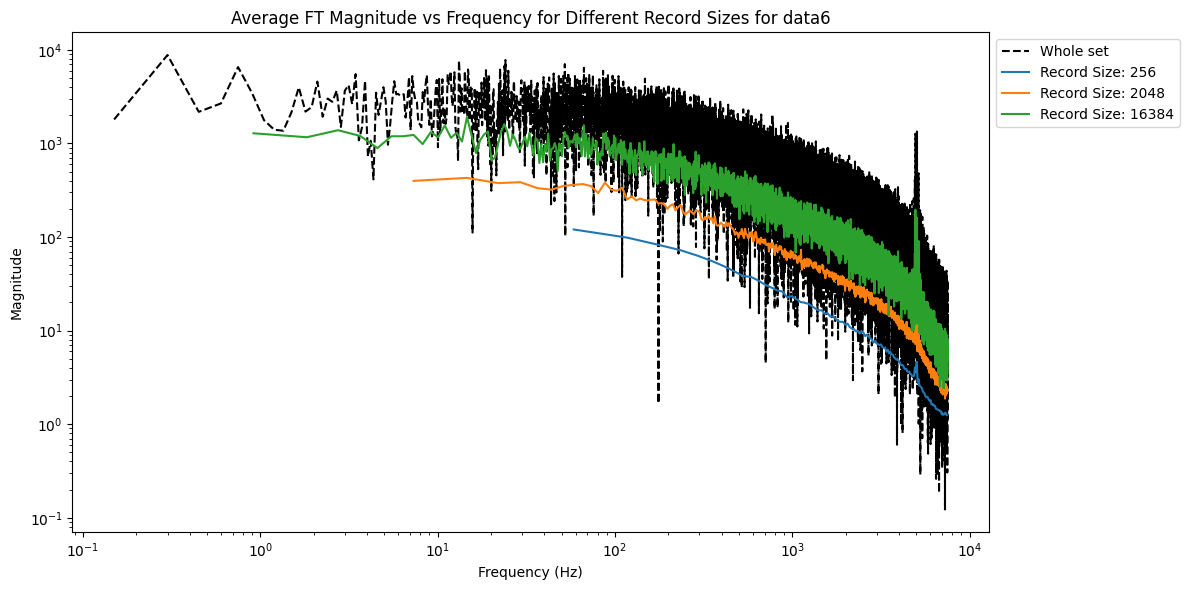

In [13]:
# Plot FFT magnitudes for set6
plot_fft_magnitudes(set6)

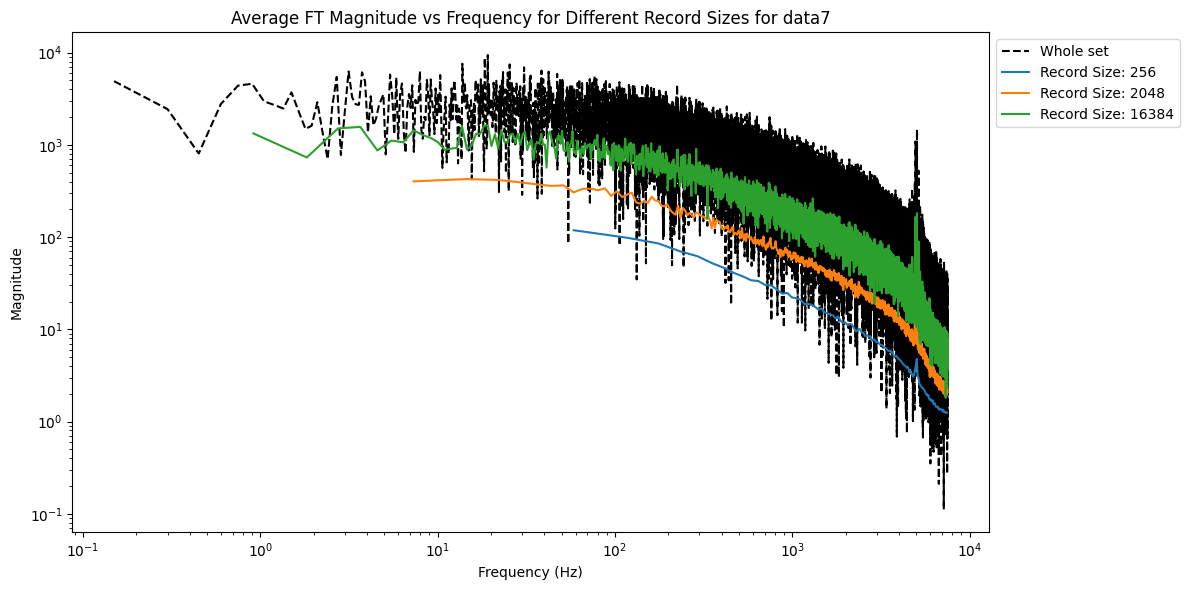

In [14]:
# Plot FFT magnitudes for set7
plot_fft_magnitudes(set7)

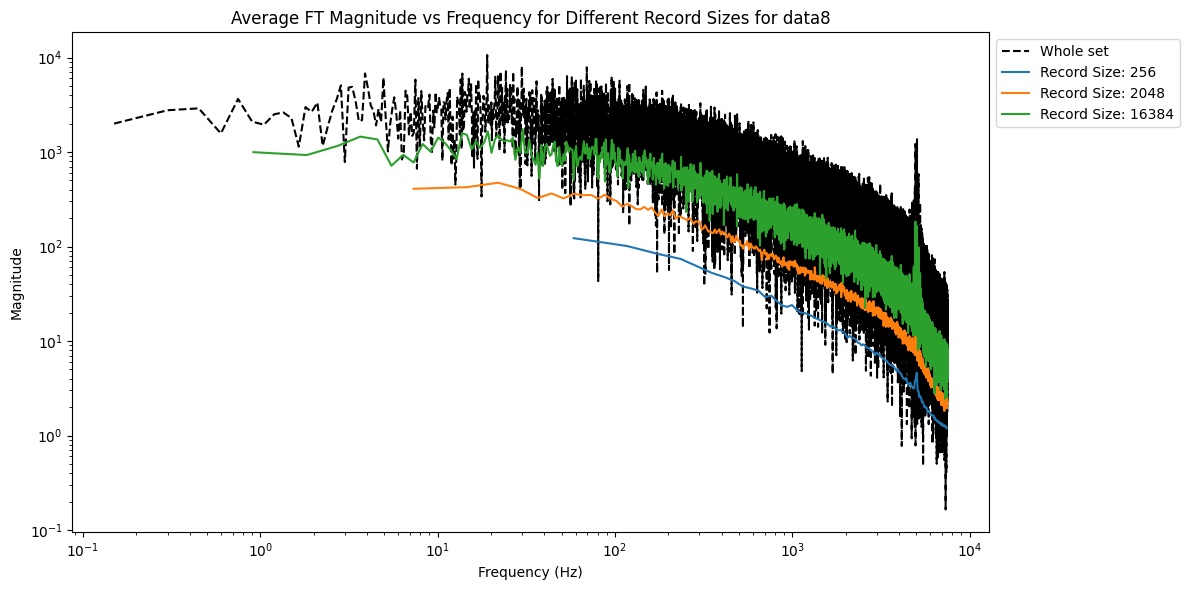

In [15]:
# Plot FFT magnitudes for set8
plot_fft_magnitudes(set8)

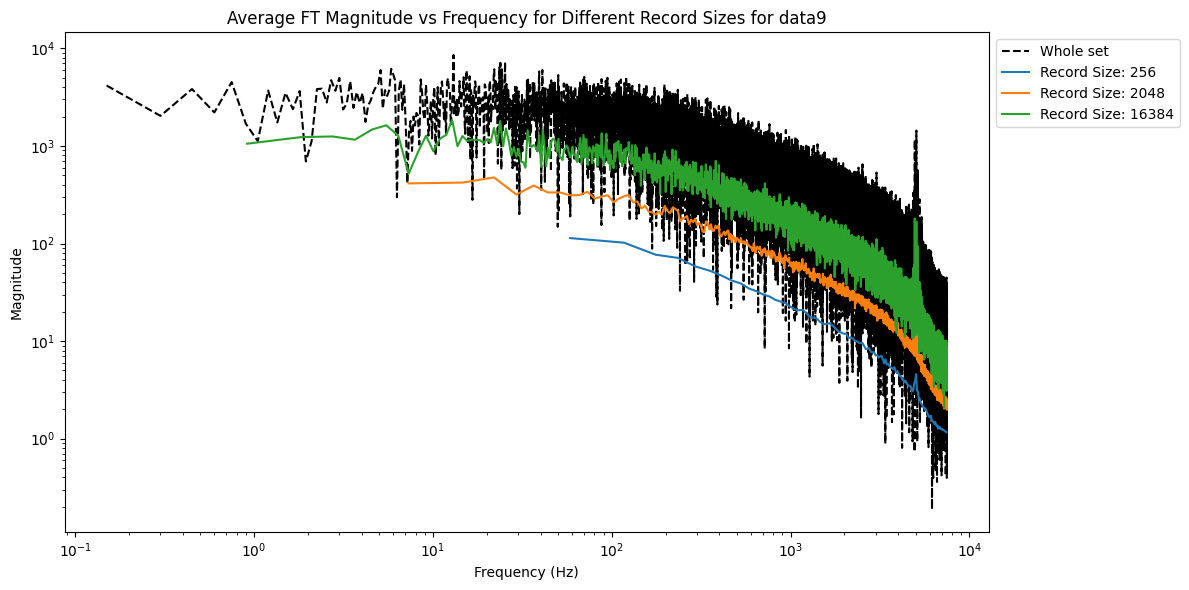

In [16]:
# Plot FFT magnitudes for set9
plot_fft_magnitudes(set9)

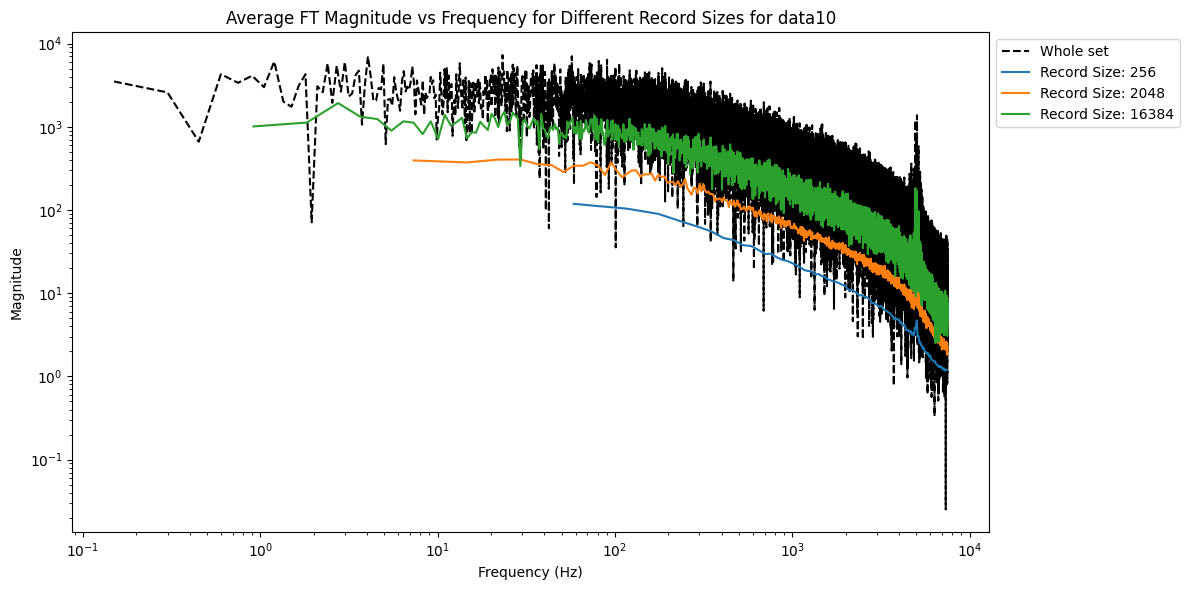

In [17]:
# Plot FFT magnitudes for set10
plot_fft_magnitudes(set10)